In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import time
import os
import pickle
from collections import defaultdict

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 1
input_shape = 28*28
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)
print(device)

cuda


In [3]:
# 3. Download dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.98MB/s]


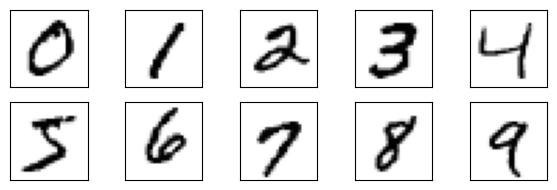

In [5]:
images, labels = full_train_dataset.data , full_train_dataset.targets
#lets visualize:
fig, ax = plt.subplots(nrows =2, ncols=5,sharex = True, sharey = True , figsize = (6,2))
ax = ax.flatten()
for i in range(10):
  img = images[labels == i][0]
  ax[i].imshow(img,cmap =  'Greys')
  #plt.title(f"Label: {i}")

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [7]:
# 4. Split into train and validation sets (80/20 split)
train_size = int(0.7 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [8]:
btSize = 32
# 5. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=btSize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=btSize)
test_loader = DataLoader(test_dataset, batch_size=btSize)

In [43]:
def draw_images(images,no_images = 5):
  #input: batch of images: [#batch, channels, Height , widht]
  displayed_images = images[:no_images]

  fig, ax = plt.subplots(nrows =1, ncols=no_images,sharex = True, sharey = True , figsize = (6,2))
  ax = ax.flatten()
  for i in range(no_images):
    img = images[i].reshape(28,28)
    ax[i].imshow(img,cmap =  'Greys')
  ax[0].set_xticks([])
  ax[0].set_yticks([])
  plt.tight_layout()
  plt.show()


In [49]:
#784 ===> z = 8 ==>784
class Encoder(nn.Module):
  def __init__(self, input_dim , z_dim):
    super().__init__()
    self.net = nn.Sequential(
        #we recieve image:
        nn.Flatten(),#[batch, 1, 28, 28] ==> [batch,1*28*28 ]
        nn.Linear(input_dim, out_features =256 ),
        nn.ReLU(),
        nn.Linear(256, out_features = z_dim),
        nn.ReLU()
    )
  def forward(self, x):
    z = self.net(x)#laten space
    return z

class Decoder(nn.Module):
  def __init__(self, input_dim , z_dim):
    super().__init__()
    self.net = nn.Sequential(
        #we recieve z vector:
        nn.Linear(z_dim, out_features =256 ),
        nn.ReLU(),
        nn.Linear(256, out_features = input_dim),# output [-inf, inf]
        #nn.ReLU()# image in range(0-1)to be the same input range values
        #relu function [0 , inf] don't be useful here. sigmoid [0,1]
        nn.Sigmoid(), # output : [batch_size , 784]
        torch.nn.Unflatten(dim =1 , unflattened_size = (1,28, 28))#[bath, 1,28, 28 ]
        #we need to represent it to be image
    )
  def forward(self, x):
    z = self.net(x)#laten space
    return z

class Autoencoder(nn.Module):
  def __init__(self, input_dim , z_dim):
    super().__init__()
    self.encoder = Encoder(input_dim , z_dim) #take encoder object
    self.decoder = Decoder(input_dim , z_dim) #take Decodr object
  def forward(self, x):
    z = self.encoder(x)
    #print(z.shape)
    image_ = self.decoder(z)
    return image_

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:

# Set the path
PATH = '/content/drive/MyDrive/NeuroTech/Preparation_Sun_Wednesday/SixthSession/'

# Ensure the directory exists
os.makedirs(PATH, exist_ok=True)

# Try to load saved model and parameters
try:
    print("Trying to load saved model and parameters...")

    # Autoencoder
    ae = Autoencoder(input_dim=28*28, z_dim=8).to(device)
    ae.load_state_dict(torch.load(PATH + 'ae_weights.pth'))
    # Epoch and history
    finished_epochs = pickle.load(open(PATH + 'finished_epochs.pkl', 'rb'))
    history = pickle.load(open(PATH + 'history.pkl', 'rb'))

    print("AutoEncoder and parameters loaded successfully.")

except Exception as e:
    print("Initializing new model and parameters...")
    #print("Reason:", e)

    # Autoencoder
    ae = Autoencoder(input_dim=28*28, z_dim=8).to(device)

    # Initialize variables
    finished_epochs = 0
    history = defaultdict(list)
    print("New model and parameters initialized and saved.")


Trying to load saved model and parameters...
Initializing new model and parameters...
New model and parameters initialized and saved.


In [52]:
# 7. Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr = 0.001)

In [53]:
epochs = 100 - finished_epochs
current_epoch = finished_epochs
current_epoch

0

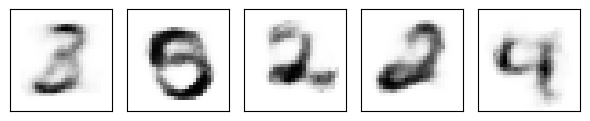

epoch:1, loss_Train: 0.0403 , loss_Validation: 0.0329
Time Elapsed: 0.15 min


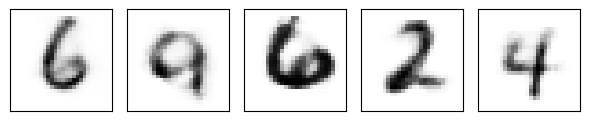

epoch:3, loss_Train: 0.0299 , loss_Validation: 0.0295
Time Elapsed: 0.44 min


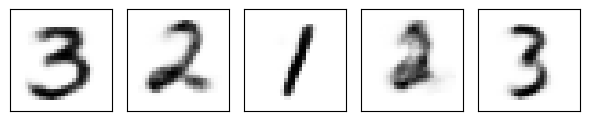

epoch:5, loss_Train: 0.0283 , loss_Validation: 0.0283
Time Elapsed: 0.73 min


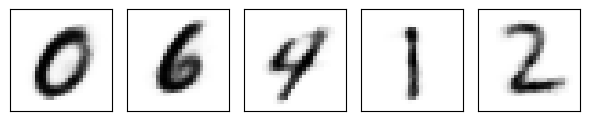

epoch:7, loss_Train: 0.0275 , loss_Validation: 0.0277
Time Elapsed: 1.04 min


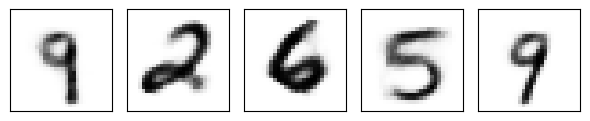

epoch:9, loss_Train: 0.0269 , loss_Validation: 0.0270
Time Elapsed: 1.33 min


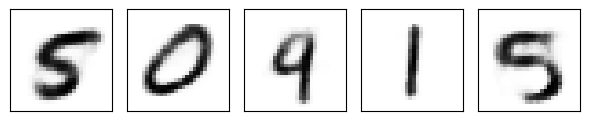

epoch:11, loss_Train: 0.0264 , loss_Validation: 0.0267
Time Elapsed: 1.64 min


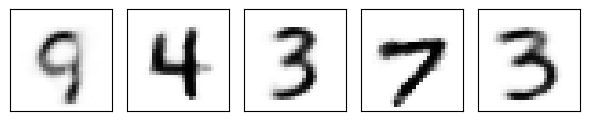

epoch:13, loss_Train: 0.0260 , loss_Validation: 0.0265
Time Elapsed: 1.92 min


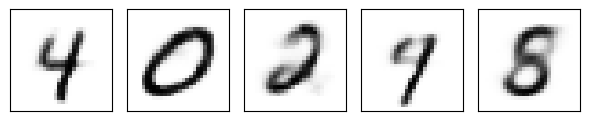

epoch:15, loss_Train: 0.0256 , loss_Validation: 0.0260
Time Elapsed: 2.22 min


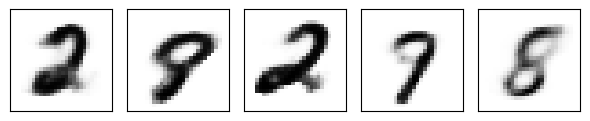

epoch:17, loss_Train: 0.0253 , loss_Validation: 0.0260
Time Elapsed: 2.52 min


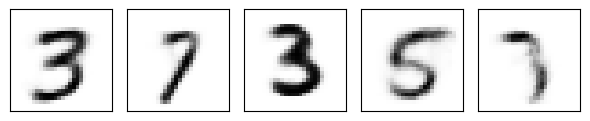

epoch:19, loss_Train: 0.0251 , loss_Validation: 0.0258
Time Elapsed: 2.80 min


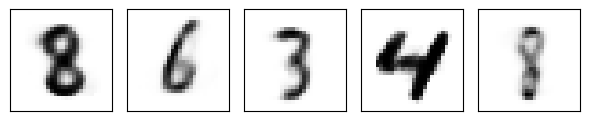

epoch:21, loss_Train: 0.0248 , loss_Validation: 0.0256
Time Elapsed: 3.09 min


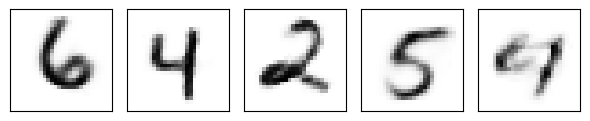

epoch:23, loss_Train: 0.0247 , loss_Validation: 0.0255
Time Elapsed: 3.39 min


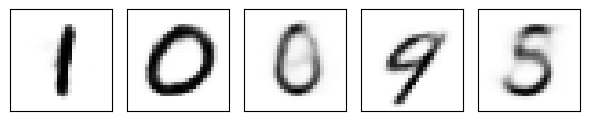

epoch:25, loss_Train: 0.0245 , loss_Validation: 0.0254
Time Elapsed: 3.68 min


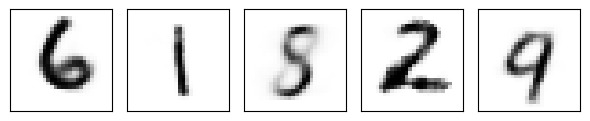

epoch:27, loss_Train: 0.0244 , loss_Validation: 0.0254
Time Elapsed: 3.97 min


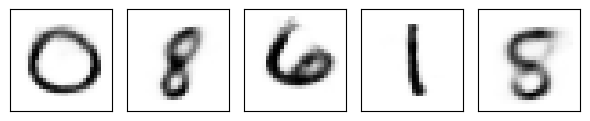

epoch:29, loss_Train: 0.0242 , loss_Validation: 0.0253
Time Elapsed: 4.26 min


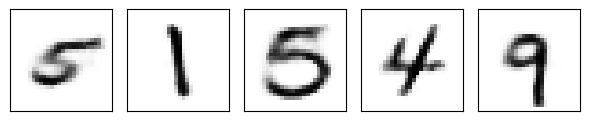

epoch:31, loss_Train: 0.0241 , loss_Validation: 0.0252
Time Elapsed: 4.54 min


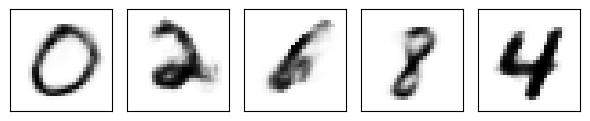

epoch:33, loss_Train: 0.0240 , loss_Validation: 0.0250
Time Elapsed: 4.83 min


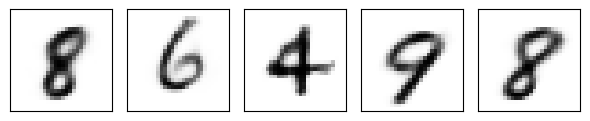

epoch:35, loss_Train: 0.0239 , loss_Validation: 0.0250
Time Elapsed: 5.13 min


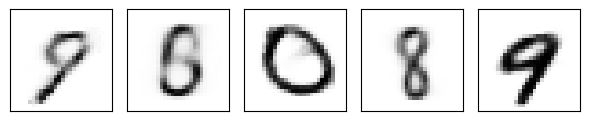

epoch:37, loss_Train: 0.0238 , loss_Validation: 0.0251
Time Elapsed: 5.41 min


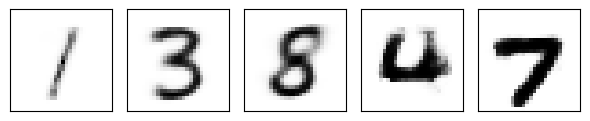

epoch:39, loss_Train: 0.0237 , loss_Validation: 0.0250
Time Elapsed: 5.70 min


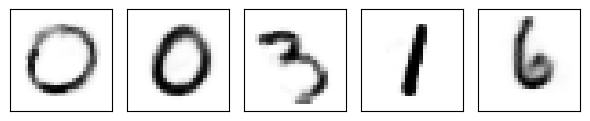

epoch:41, loss_Train: 0.0236 , loss_Validation: 0.0252
Time Elapsed: 6.00 min


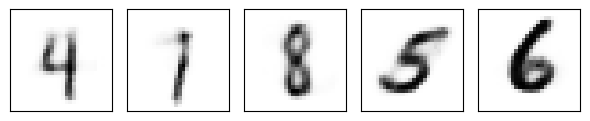

epoch:43, loss_Train: 0.0236 , loss_Validation: 0.0249
Time Elapsed: 6.28 min


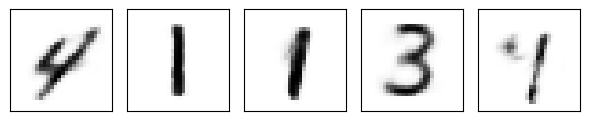

epoch:45, loss_Train: 0.0235 , loss_Validation: 0.0250
Time Elapsed: 6.58 min


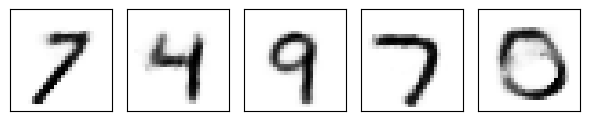

epoch:47, loss_Train: 0.0234 , loss_Validation: 0.0249
Time Elapsed: 6.87 min


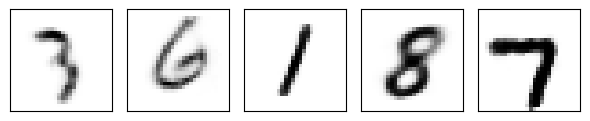

epoch:49, loss_Train: 0.0234 , loss_Validation: 0.0249
Time Elapsed: 7.16 min


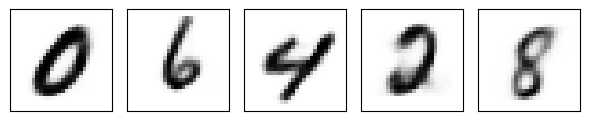

epoch:51, loss_Train: 0.0233 , loss_Validation: 0.0248
Time Elapsed: 7.45 min


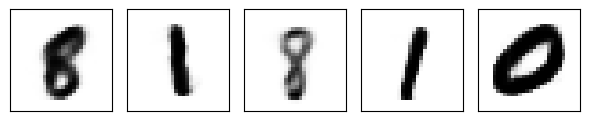

epoch:53, loss_Train: 0.0233 , loss_Validation: 0.0248
Time Elapsed: 7.74 min


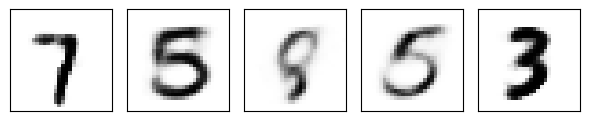

epoch:55, loss_Train: 0.0232 , loss_Validation: 0.0250
Time Elapsed: 8.03 min


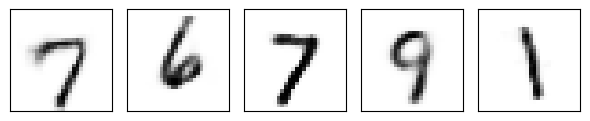

epoch:57, loss_Train: 0.0231 , loss_Validation: 0.0246
Time Elapsed: 8.32 min


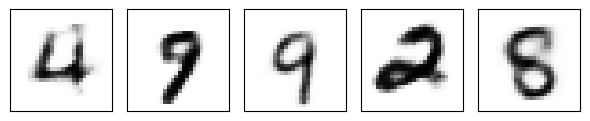

epoch:59, loss_Train: 0.0223 , loss_Validation: 0.0236
Time Elapsed: 8.61 min


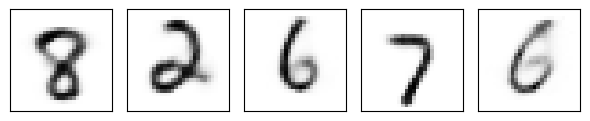

epoch:61, loss_Train: 0.0219 , loss_Validation: 0.0233
Time Elapsed: 8.89 min


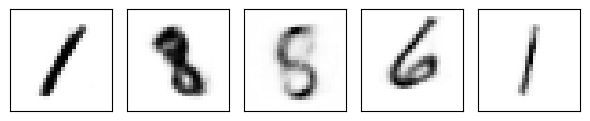

epoch:63, loss_Train: 0.0217 , loss_Validation: 0.0233
Time Elapsed: 9.19 min


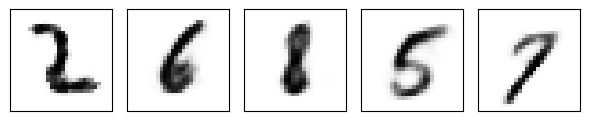

epoch:65, loss_Train: 0.0215 , loss_Validation: 0.0230
Time Elapsed: 9.48 min


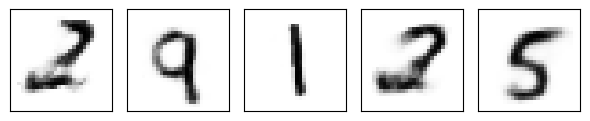

epoch:67, loss_Train: 0.0213 , loss_Validation: 0.0229
Time Elapsed: 9.76 min


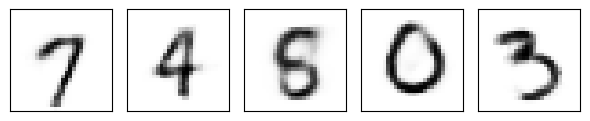

epoch:69, loss_Train: 0.0212 , loss_Validation: 0.0228
Time Elapsed: 10.05 min


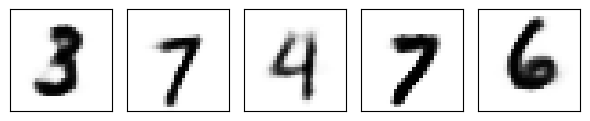

epoch:71, loss_Train: 0.0211 , loss_Validation: 0.0227
Time Elapsed: 10.35 min


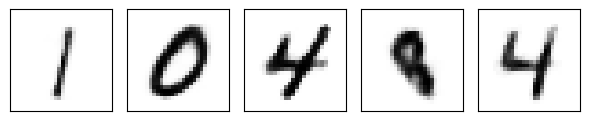

epoch:73, loss_Train: 0.0210 , loss_Validation: 0.0226
Time Elapsed: 10.64 min


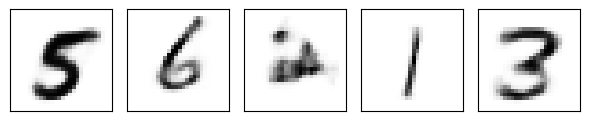

epoch:75, loss_Train: 0.0209 , loss_Validation: 0.0226
Time Elapsed: 10.93 min


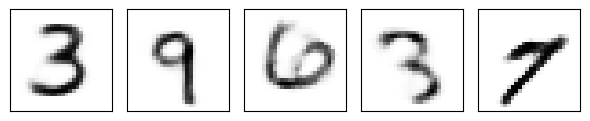

epoch:77, loss_Train: 0.0209 , loss_Validation: 0.0226
Time Elapsed: 11.22 min


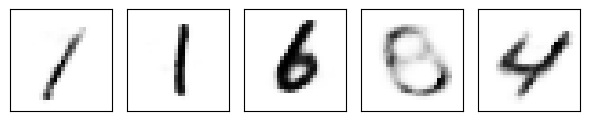

epoch:79, loss_Train: 0.0208 , loss_Validation: 0.0225
Time Elapsed: 11.51 min


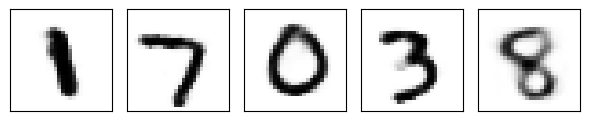

epoch:81, loss_Train: 0.0207 , loss_Validation: 0.0224
Time Elapsed: 11.79 min


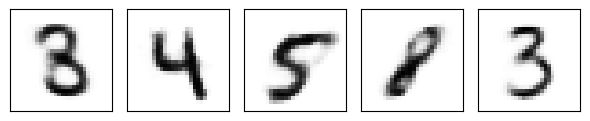

epoch:83, loss_Train: 0.0206 , loss_Validation: 0.0226
Time Elapsed: 12.09 min


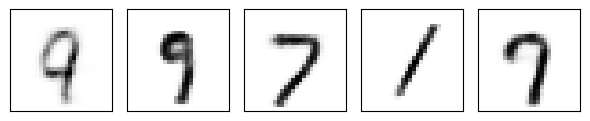

epoch:85, loss_Train: 0.0206 , loss_Validation: 0.0224
Time Elapsed: 12.37 min


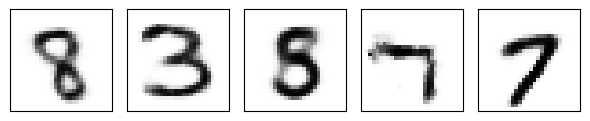

epoch:87, loss_Train: 0.0205 , loss_Validation: 0.0223
Time Elapsed: 12.66 min


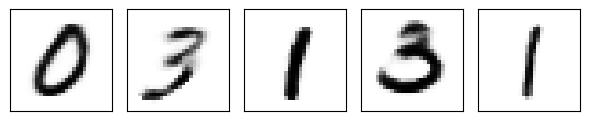

epoch:89, loss_Train: 0.0205 , loss_Validation: 0.0223
Time Elapsed: 12.95 min


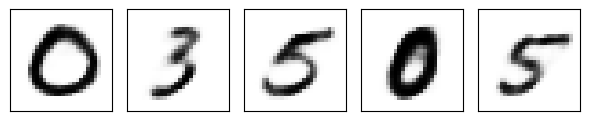

epoch:91, loss_Train: 0.0204 , loss_Validation: 0.0223
Time Elapsed: 13.25 min


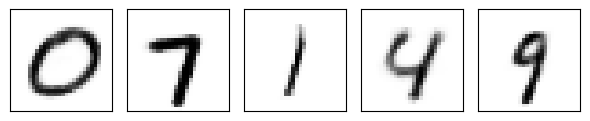

epoch:93, loss_Train: 0.0204 , loss_Validation: 0.0223
Time Elapsed: 13.54 min


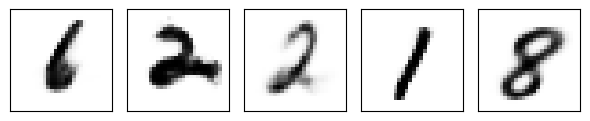

epoch:95, loss_Train: 0.0203 , loss_Validation: 0.0222
Time Elapsed: 13.83 min


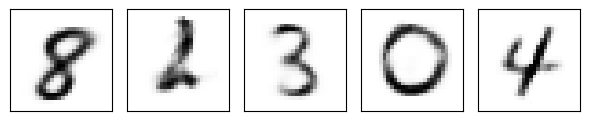

epoch:97, loss_Train: 0.0203 , loss_Validation: 0.0221
Time Elapsed: 14.12 min


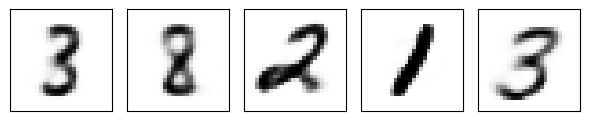

epoch:99, loss_Train: 0.0202 , loss_Validation: 0.0222
Time Elapsed: 14.41 min
Time Elapsed: 14.55 min


In [54]:
#when we need to save the model weights for learning for many times not one time
patience = 10
counter = 0
best_val_loss = float('inf')
start_time = time.time()
for epoch in range(epochs):
  loss_per_epoch = 0
  Acc_val = 0
  for images , _ in train_loader:
    #to GPU
    images = images.to(device)
    # forward
    reconstructed_images = ae(images)
    # calculate loss fn
    loss = criterion(reconstructed_images, images)
    loss_per_epoch += loss.item()


    # reset gradients
    optimizer.zero_grad()
    # calculate gradients
    loss.backward()
    # update weights
    optimizer.step()

  #UserWarning: Using a target size (labels)(torch.Size([64])) that is different to the input size (y_predict)(torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  # warning that make results wrong
  loss_per_epoch /= len(train_loader)
  history['train_loss'].append(loss_per_epoch)

  # validation Check
  with torch.no_grad():
    validation_loss = 0
    for images_valid,_  in val_loader:
      images_valid = images_valid.to(device)
      reconstructed_images_valid = ae(images_valid)
      loss = criterion(reconstructed_images_valid, images_valid)
      validation_loss += loss.item()

    validation_loss /= len(val_loader)

    if validation_loss < best_val_loss:#this true when validation loss is always decreases
      best_val_loss = validation_loss
      counter = 0
    else: #this will happen when validation loss increases or remain the same
      counter += 1
      if counter >= patience:
        print("Early Stopping")
        #save weights
        torch.save(ae.state_dict(), PATH + 'ae_weights.pth')
        pickle.dump(history,open(PATH+'history.pkl','wb') )
        break
    history['val_loss'].append(validation_loss)

    current_epoch += 1
    if epoch %2 ==0:
      #save weights
      finished_epochs = current_epoch
      #we need to save finished_epochs:
      draw_images(reconstructed_images.cpu().detach().numpy())

      pickle.dump(finished_epochs, open(PATH + 'finished_epochs.pkl', 'wb'))#save object
      pickle.dump(history,open(PATH+'history.pkl','wb') )#save history
      torch.save(ae.state_dict(), PATH + 'ae_weights.pth')
      print(f"epoch:{current_epoch}, loss_Train: {loss_per_epoch:0.4f} , loss_Validation: {validation_loss:0.4f}")
      print(f"Time Elapsed: {(time.time() - start_time)/60 :0.2f} min")#after two epochs
print(f"Time Elapsed: {(time.time() - start_time)/60 :0.2f} min")#after training

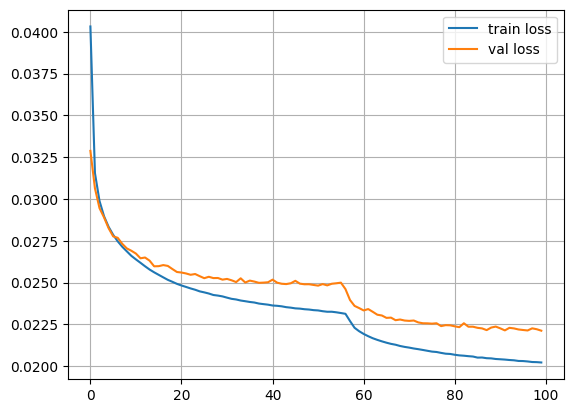

In [55]:
#draw learing Curves:#losses
plt.plot(history['train_loss'], label = 'train loss')
plt.plot(history['val_loss'], label = 'val loss')
plt.legend()
plt.grid(True)
plt.show()#the curves show we can improve more.

2


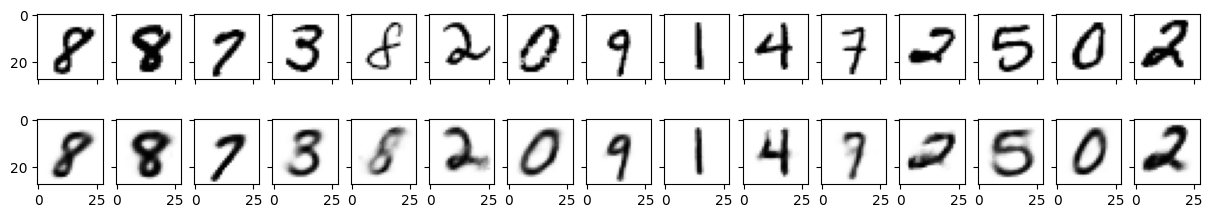

In [56]:
#visual Evaluation :::
n_images = 15
original_images = images[:n_images]
decoded_images = ae(images[:n_images])
fig , axes = plt.subplots(nrows = 2, ncols = n_images , figsize = (15,2.5),sharex = True, sharey = True)
print(len(axes))
for i in range(n_images):
  for ax, im in zip(axes,[original_images, decoded_images]):
    current_im = im[i].detach().cpu()
    ax[i].imshow(current_im.view((28,28)), cmap = "binary")#view is function of pytorch tensor